# Numerics of Machine Learning
# Solution to Exercise Sheet No. 11 — Optimization for Deep Learning

---
University of Tübingen, Winter Term 2022/23
&copy; N. Bosch, J. Grosse, P. Hennig, A. Kristiadi, M. Pförtner, J. Schmidt, F. Schneider, L. Tatzel, J. Wenger, 2022 CC BY-NC-SA 3.0

## Introduction

This "solution" fixes the artificially introduced bugs and highlightes them in the code with a #[BUG!] comment

It only does little hyperparameter tuning (for both the training algorithm and the model) and doesn't change the training time. 
Certainly, more extensive changes could be done to improve this model. However, the provided notebook trains a model to >93% accuracy.

In [1]:
from torch import nn, optim
from torch.utils.data import dataloader, random_split
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from backpack import extend
from cockpit import Cockpit, CockpitPlotter, quantities
from cockpit.utils.configuration import configuration, schedules

import matplotlib.pyplot as plt

from utils import (
    get_default_device,
    accuracy_fn,
    eval_model,
    visualize_results,
    set_seeds,
    get_logpath,
)

## Loading SVHN Data

In [2]:
def build_dataloaders(batch_size, verbose=False):
    """Download the data and build dataloaders."""

    # Provide verbose output
    if verbose:
        print("** Loading Data **")

    # [BUG!] Wrong transformations that don't fit the data
    basic_transform = transforms.Compose([transforms.ToTensor()])

    # [BUG!] Loading the train data twice!
    train_data = datasets.SVHN(
        root="data/", split="train", transform=basic_transform, download=True
    )
    eval_data = datasets.SVHN(
        root="data/", split="test", transform=basic_transform, download=True
    )

    # Use half of the eval_data for the validation set and half for the test set
    valid_data, test_data = random_split(
        eval_data, [int(len(eval_data) / 2), int(len(eval_data) / 2)]
    )

    # Build dataloaders
    train_loader = dataloader.DataLoader(train_data, batch_size, shuffle=True)
    val_loader = dataloader.DataLoader(valid_data, batch_size)
    test_loader = dataloader.DataLoader(test_data, batch_size)

    # Create dict with names
    dataloaders = {
        "train": train_loader,
        "validation": val_loader,
        "test": test_loader,
    }

    return dataloaders

### Test Dataloaders

This is a quick test to visualize the data for all three dataloaders (train/valid/test)

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
Checking the train set:
Image shape:  torch.Size([9, 3, 32, 32])
Image labels:  tensor([5, 6, 5, 7, 4, 2, 4, 2, 1])
Checking the validation set:
Image shape:  torch.Size([9, 3, 32, 32])
Image labels:  tensor([1, 5, 1, 4, 9, 9, 2, 4, 0])
Checking the test set:
Image shape:  torch.Size([9, 3, 32, 32])
Image labels:  tensor([7, 5, 6, 3, 2, 2, 7, 0, 2])


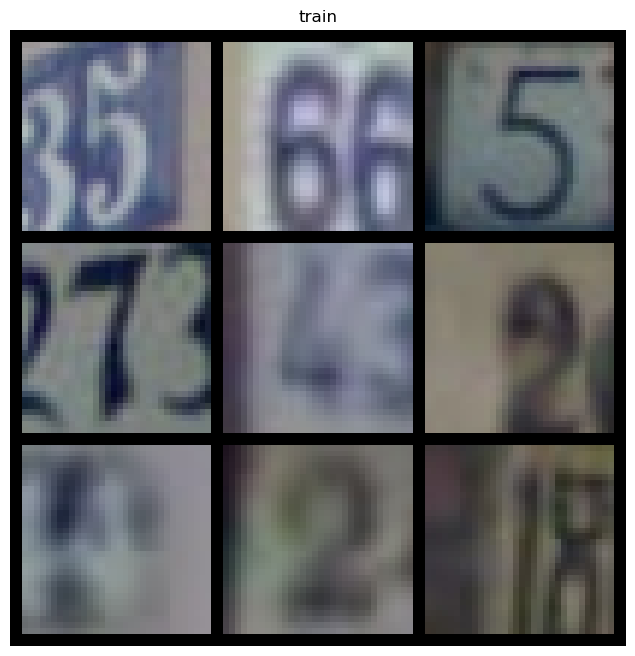

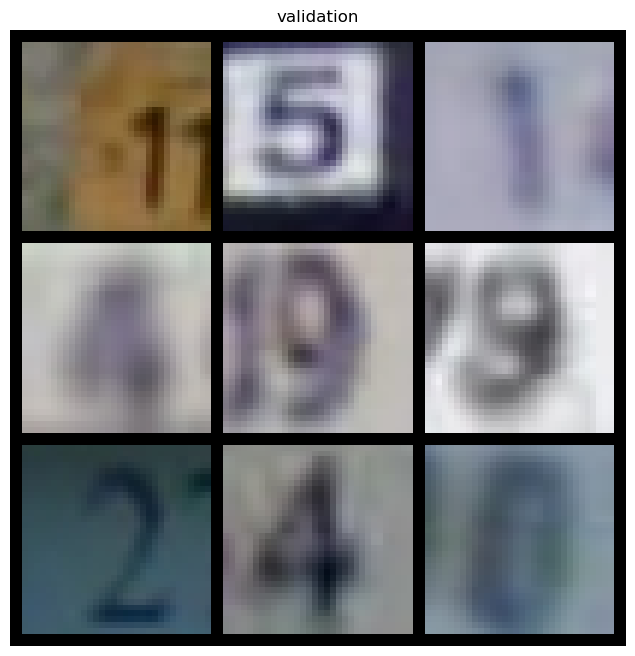

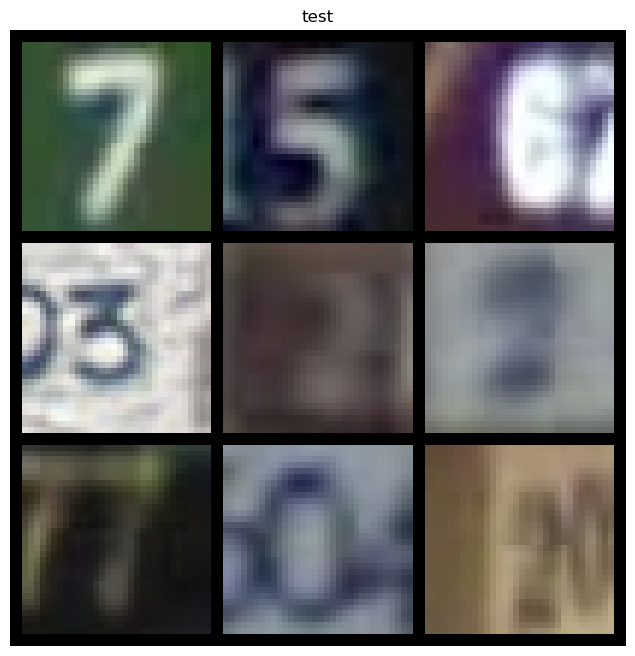

In [3]:
dataloaders = build_dataloaders(batch_size=9)

for dl in dataloaders:
    for batch_iter, batch in enumerate(dataloaders[dl]):
        if batch_iter == 0:
            inputs, targets = batch[0], batch[1]

            print(f"Checking the {dl} set:")
            print("Image shape: ", inputs.shape)
            print("Image labels: ", targets)
            plt.figure(figsize=(16, 8))
            plt.title(dl)
            plt.axis("off")
            plt.imshow(make_grid(inputs, nrow=3).permute((1, 2, 0)))
        else:
            break

## Defining the Model

In [4]:
def CNN(verbose=False):
    """Basic Conv-Net for SVHN."""
    if verbose:
        print("** Creating Model **")

    # [BUG!] Switched to ReLU.
    # Note that this is not a "bug" in the strict sense.
    # But switching the activation function improved performance slightly for my setup
    # I also added batch normalization layers.
    # More extensive experiments would be required
    return nn.Sequential(
        nn.Conv2d(3, 32, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 32, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 64, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 64, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2),
        nn.Conv2d(64, 128, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(128, 128, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(2048, 128),
        nn.ReLU(),
        nn.Linear(128, 10),
    )

# Train Loop

In [5]:
# Device
DEVICE = get_default_device()


def train(num_epochs=10, batch_size=256, lr=2e-3, verbose=False, cockpit=True):
    """Train the model."""

    # Set random seeds
    set_seeds()

    # Data
    dataloaders = build_dataloaders(batch_size, verbose)

    # Model
    model = CNN(verbose=verbose)
    if cockpit:
        model = extend(model)
    model.to(DEVICE)

    # Loss
    loss_fn = nn.CrossEntropyLoss(reduction="mean")
    individual_loss_fn = nn.CrossEntropyLoss(reduction="none")
    if cockpit:
        loss_fn = extend(loss_fn)
        individual_loss_fn = extend(individual_loss_fn)

    # Eval
    eval_fn = accuracy_fn
    results = {
        "train": {"loss": [], "accuracy": []},
        "validation": {"loss": [], "accuracy": []},
        "test": {"loss": [], "accuracy": []},
    }

    # Cockpit
    if cockpit:
        quants = [
            quantities.Alpha(schedules.linear(interval=10)),
            quantities.Distance(schedules.linear(interval=1)),
            quantities.GradNorm(schedules.linear(interval=1)),
            quantities.InnerTest(schedules.linear(interval=10)),
            quantities.Loss(schedules.linear(interval=1)),
            quantities.NormTest(schedules.linear(interval=10)),
            quantities.OrthoTest(schedules.linear(interval=10)),
            quantities.UpdateSize(schedules.linear(interval=1)),
        ]
        cockpit = Cockpit(
            model.parameters(),
            quantities=quants,
        )

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # [BUG!] Incorrect learning rate schedule (exponentially increasing!)

    # Train Loop
    global_step = 0
    for epoch in range(num_epochs):
        if verbose:
            print(f"** Starting Epoch {epoch} on {DEVICE}**")

        for batch_iter, batch in enumerate(dataloaders["train"]):
            # Required for Batch Norm (but not needed in the original model)
            model.train()

            # [BUG!] Forgot to set gradients to zero
            optimizer.zero_grad()

            # Get inputs and labels
            inputs, targets = batch[0].to(DEVICE), batch[1].to(DEVICE)

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            losses = individual_loss_fn(outputs, targets)

            # Backward pass
            if cockpit:
                with cockpit(
                    global_step,
                    info={
                        "batch_size": inputs.shape[0],
                        "individual_losses": losses,
                        "loss": loss,
                        "optimizer": optimizer,
                    },
                ):
                    loss.backward(create_graph=cockpit.create_graph(global_step))
            else:
                loss.backward()

            # Update step
            optimizer.step()
            global_step += 1

        # Per-epoch eval
        results = eval_model(
            model, epoch, results, DEVICE, loss_fn, eval_fn, dataloaders, verbose
        )

        # Cockpit Log
        if cockpit:
            cockpit.log(
                global_step,
                epoch,
                results["train"]["loss"][-1],
                results["validation"]["loss"][-1],
                results["test"]["loss"][-1],
                results["train"]["accuracy"][-1],
                results["validation"]["accuracy"][-1],
                results["test"]["accuracy"][-1],
                lr,
            )

    # Write Cockpit to json file.
    if cockpit:
        cockpit.write(get_logpath())

    return results

## Train the Model and Show Results

** Loading Data **
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat
** Creating Model **
** Starting Epoch 0 on cuda**
 * Eval model at the end of Epoch 0
** Starting Epoch 1 on cuda**
 * Eval model at the end of Epoch 1
** Starting Epoch 2 on cuda**
 * Eval model at the end of Epoch 2
** Starting Epoch 3 on cuda**
 * Eval model at the end of Epoch 3
** Starting Epoch 4 on cuda**
 * Eval model at the end of Epoch 4
** Starting Epoch 5 on cuda**
 * Eval model at the end of Epoch 5
** Starting Epoch 6 on cuda**
 * Eval model at the end of Epoch 6
** Starting Epoch 7 on cuda**
 * Eval model at the end of Epoch 7
** Starting Epoch 8 on cuda**
 * Eval model at the end of Epoch 8
** Starting Epoch 9 on cuda**
 * Eval model at the end of Epoch 9
The best achieved train/valid/tests accuracies are:  0.9873732203065919 / 0.9363091579594346 / 0.9322372464658881
CPU times: user 2min 57s, sys: 742 ms, total: 2min 57s
Wall time: 2min 55

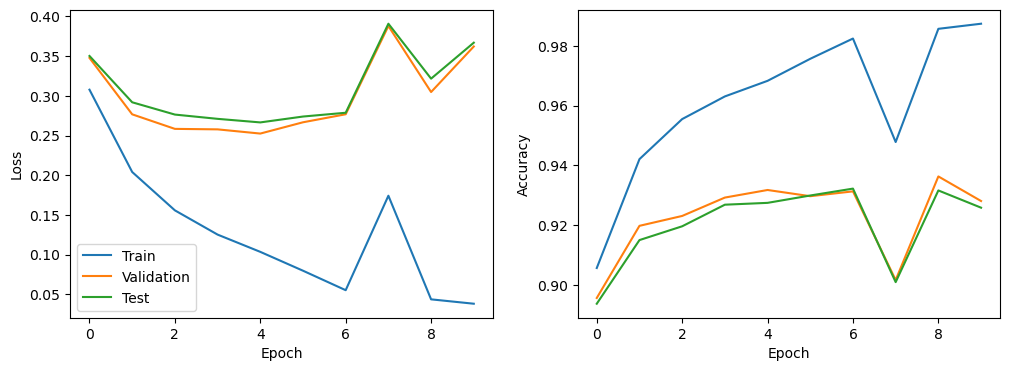

In [6]:
%%time

verbose = True

results = train(verbose=verbose, cockpit=False)
visualize_results(results, verbose)

## Show Cockpit

In [ ]:
# Turned of Cockpit due to the use of batch normalization.
# Batch norm correlates the individual gradients in a batch which means
# individual gradients become undefined.

# Plot results from file
plotter = CockpitPlotter()
plotter.plot(get_logpath())